In [4]:
%pylab inline
import pandas as pd
import json
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(
    '/storage/mgymrek/workspace/capillary-electrophoresis-webserver/capillaryelectrophoresis-e683d5dd37a2.json', scope)
gc = gspread.authorize(credentials)

def LoadGSheet(wks):
    data = wks.get_all_values()
    headers = data.pop(0)
    return pd.DataFrame(data, columns=headers)

Populating the interactive namespace from numpy and matplotlib


In [8]:
############### Load list of loci to consider ###########
loci = pd.read_csv('../data/csv/1000g_loci.csv')
primer_ids = set(loci["LocusID"])

In [45]:
############### Load product sizes from google sheet ###########
psdata = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("product size"))
psdata = psdata[psdata["PrimerID"].isin(primer_ids)][["PrimerID","SampleID","Product size"]]
psdata.columns = ["PrimerID", "SampleID","ProductSize"]
psdata["SampleID"] = psdata["SampleID"].apply(lambda x: x.strip())

# Sample product sizes
samp_prod_sizes = psdata[~psdata["SampleID"].isin(["Reference", "reference"])]
samp_prod_sizes = samp_prod_sizes[samp_prod_sizes["ProductSize"].apply(lambda x: "/" in x and x.split("/")[1].strip() != "")]
samp_prod_sizes[["prd_size_1", "prd_size_2"]] = samp_prod_sizes["ProductSize"].str.split('/', expand=True)[[0,1]].astype(float).round(0)


In [65]:
############### Load ref product sizes ###########
ref_prod_sizes = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("RefProductSizes"))

In [36]:
############### Load product sizes from VCFs ###########
# load json for gangstr
with open('../data/json/gangstr_calls.json', 'r') as f:
    gangstr_calls = json.load(f)
# load json for hipstr
with open('../data/json/hipstr_calls.json', 'r') as f:
    hipstr_calls = json.load(f)


>> SCA1 offset=-3/-3 nummatch=53/61



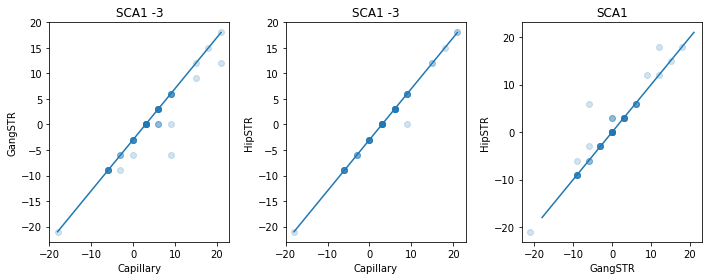

In [72]:
# Y = X + offset
def find_offset (X, Y, period):
    newX = [X[i] for i in range(len(X)) if not np.isnan(Y[i])]
    newY = [item for item in Y if not np.isnan(item)]
    
    if len(newX) == 0: return np.nan, np.nan, np.nan
    # measure: diffs in sizes
    most_matches = -10
    best_diffs = 100000
    best_offset = -1000
    for offset in range(-30,30):
        x_plus_off = [x + offset for x in newX]
        
        # Get matches after round to nearest repeat unit
        rounded_x = [round(item/period) for item in x_plus_off]
        rounded_y = [round(item/period) for item in newY]
        num_matches = sum(np.equal(rounded_x, rounded_y))
        
        # Get diffs. Take top %percentile since we don't know how many calls are wrong
        diffs = [abs(x_plus_off[i]-newY[i]) for i in range(len(x_plus_off))]
        diff = np.max(sorted(diffs)[0:10]) #np.median(diffs)
        
        if diff < best_diffs:
            best_diffs = diff
            best_offset = offset
            most_matches = num_matches
    return best_offset, most_matches, best_diffs

for PrimerID in ["SCA1"]: #set(ref_prod_sizes["PrimerID"]):
    try:
        period = len(loci[loci["LocusID"]==PrimerID]["Motif"].values[0])
    except:
        print("************couldn't find motif for %s"%PrimerID)
        continue
    ref_prod_size = ref_prod_sizes[ref_prod_sizes["PrimerID"]==PrimerID]["ProductSize"].values[0]    
    samp_loc_prod_sizes = samp_prod_sizes[samp_prod_sizes["PrimerID"]==PrimerID]
    
    X = [] # product size from capillary
    Y_gstr = [] # product size from gangstr
    Y_hstr = [] # product size from hipstr
    samples = [] # sample list
    
    for sample in list(samp_loc_prod_sizes["SampleID"]):
        # Extract capillary data
        cap_prod_sizes = list(samp_loc_prod_sizes.set_index('SampleID').loc[sample][['prd_size_1', 'prd_size_2']])
        
        if "prd_size_1" in cap_prod_sizes: continue
        gb_cap = sorted([float(i) - float(ref_prod_size) for i in cap_prod_sizes])
        if sum(np.isnan(gb_cap)) > 0: continue 
        X.extend(gb_cap)
        samples.extend([sample]*2)

        # Extract gangstr and hipstr data
        try:
            gb_gstr = sorted([float(i) for i in gangstr_calls[PrimerID][sample]['gb'].split(',')])
        except: gb_gstr = [np.nan, np.nan]
        if len(gb_gstr) == 1: gb_gstr = [gb_gstr[0]]*2 # for chrX ones
        Y_gstr.extend(gb_gstr)
            
        try:
            gb_hstr = sorted([float(i) for i in hipstr_calls[PrimerID][sample]['gb'].split(',')])
        except:
            gb_hstr = [np.nan, np.nan]
        Y_hstr.extend(gb_hstr)  
        
    if len(X) == 0: continue
    offset_gstr, num_matches_gstr, diff_gstr = find_offset(X, Y_gstr, period)
    offset_hstr, num_matches_hstr, diff_hstr = find_offset(X, Y_hstr, period)

    print(f'\n>> {PrimerID} offset={offset_gstr}/{offset_hstr} nummatch={num_matches_gstr}/{num_matches_hstr}\n')

    xvals = [np.min(X), np.max(X)]
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(131)
    ax.set_title(PrimerID + " %s"%offset_gstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("GangSTR")
    ax.scatter(X, Y_gstr, alpha=0.2)
    Y_offset = [item+offset_gstr for item in xvals]
    ax.plot(xvals, Y_offset)
    
    ax = fig.add_subplot(132)
    ax.set_title(PrimerID + " %s"%offset_hstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("HipSTR")
    ax.scatter(X, Y_hstr, alpha=0.2)
    Y_offset = [item+offset_hstr for item in xvals]
    ax.plot(xvals, Y_offset)
    
    ax = fig.add_subplot(133)
    ax.set_title(PrimerID)
    ax.set_xlabel("GangSTR")
    ax.set_ylabel("HipSTR")
    ax.scatter(Y_gstr, Y_hstr, alpha=0.2)
    Y_offset = xvals
    ax.plot(xvals, Y_offset)

    fig.tight_layout()